# EM-алгоритм 

**Задача:** Пусть в пространстве даны $n$ точек. Мы хотим их кластеризовать.

## K-means

Вначале мы фиксируем число $k$. И рассмотрим следующий итеративный алгоритм, который делит точки на $k$ кластеров.


1. Вначале выбираем $k$ случайных из данных точек это будут центры кластеров вначале 
2. Дальше повторяем следующий алгоритм
    * Считаем для каждой точки ближайщий центр кластера. Относим эту точку к этому кластеру
    * Пересчитываем для каждого кластера центр
    
Делаем это пока происходят изменения или пока не надоест

### Вероятностная модель

Давайте предположим, что распределение точек в пространстве соответствует какой-то смеси гауссианов. Хотим найти параметры этих гауссианов и коэффициенты смеси.

Тогда, у нас есть $k$ гауссианов с параметрами $(\mu_i, \sigma_i)$. Есть точки $x_i$ полученных в результате сэмплирования этого распределения. Хотим найти такие $(\mu_i, \sigma_i)$ и $\overline{\pi}$, чтобы правдоподобие было максимальным. То есть, хотим найти максимум выражения$$
\prod_{i = 1}^n p(x | \overline{\mu}, \overline{\sigma}, \overline{\pi}) = \prod_{i = 1}^n \sum_{j = 1}^n \pi_j \frac{1}{\sqrt{2\pi \sigma_j}}e^{-\frac{(x_i-\mu_j)^2}{2\sigma_j^2}}$$

Как раньше мы такое делали? Мы брали логарифм и оптимизировали его. Но тут у нас произведение сумм. Если мы возьмем логарифм, у нас получится сумма логарифмов сумм, что выглядит не так просто, как в случае с логистической регрессией.

### Основная идея EM-алгоритма

Давайте введем дополнительные переменные. Пусть 
$z_{ij} = \begin{cases} 1, &\mbox{if } x_i \texttt{ from cluster j} \\ 
0, & \mbox{otherwise }\end{cases}$

То есть, давайте предположим, что нам кто-то подсказал, в какой кластер должна попасть каждая точка. Посмотрим как теперь выглядит правдоподобие:

$$p(X, Z | \overline{\mu}, \overline{\sigma}, \overline{\pi}) = \prod_{i = 1}^n \prod_{j = 1}^n \left(\frac{\pi_j}{\sqrt{2\pi \sigma_j}}e^{-\frac{(x_i-\mu_j)^2}{2\sigma_j^2}}\right)^{z_{ij}}$$

Теперь в формуле нет суммирования, поэтому давайте возьмём логарифм и будем оптимизировать логарифм правдоподобия.

Давайте также при взятии логарифма разделим все выражение на несколько независимых сумм

$$\ln p(X, Z | \overline{\mu}, \overline{\sigma}, \overline{\pi}) = \sum_{j=0}^k \left(\ln \pi_j \sum_{i = 1}^n z_{ij}\right) + \sum_{j=0}^k \left(\frac{1}{2}\frac{\ln (2\pi\sigma_j)}{2\sigma_j^2}\sum_{i = 1}^n z_{ij} (x_i - \mu_j)^2\right)$$

В таком виде уже проще оптимизировать. Видно, что коэфициенты смеси находятся сразу, а дальше нам нужно обучить $k$ гауссианов незавиcимо.

### EM-алгоритм

EM-алгоритм это итеративный алгоритм. На итерации $t$ есть $Z^{(t)} - $ вектор вероятностей, $Z_{ij}^{(t)} - $ вероятность того, что точка $x_i$ должна быть в кластере $j$ и $\theta^{(t)} - $ параметры гауссианов и коэффициенты смеси. Каждая итерация состоит из двух шагов: 

* $\texttt{E--Step (Expectation)}$ Оцениваем $Z^{(t+1)}$ через $\theta^{(t)}$. На самой первой итерации считаем, что $z_{ij} = \frac{1}{k}$
* $\texttt{M--Step (Maximize)}$ Ищем оптимальное $\theta_{t + 1}$, максимизирующее $p(X, Z^{(t + 1)} | \theta^{(t + 1)})$


Выполняем итерации, пока не сойдется процесс или пока нам не надоест

Теперь формулы

**E-step**

$$Z_{ij}^{(t + 1)} = \frac{p(x_i | \mu^{(t)}_j, \sigma^{(t)}_j)}{\sum_{l = 1}^k p(x_i | \mu^{(t)}_l, \sigma^{(t)}_l)}$$

где $p(x_i | \mu_j, \sigma_j)\, - $ плотность гауссиана, т.е. $p(x | \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

**M-step**

Вспомним формулу, которую мы оптимизируем:

$$\ln p(X, Z | \overline{\mu}, \overline{\sigma}, \overline{\pi}) = \sum_{j=0}^k \left(\ln \pi_j \sum_{i = 1}^n z_{ij}\right) + \sum_{j=0}^k \left(\frac{1}{2}\frac{\ln (2\pi\sigma_j)}{2\sigma_j^2}\sum_{i = 1}^n z_{ij} (x_i - \mu_j)^2\right)$$

* пересчитываем $\overline\pi$ вот так: $\pi_j = \frac{\sum_{i = 1}^n Z^{(t + 1)}_{ij}}{n}$


* $\mu^{(t)}_j = \mathbb{E}Z^{(t + 1)}_{*j} x_*$, а $\sigma^{(t)}_j = \sqrt{\mathbb{D}Z^{(t + 1)}_{*j} x_*}$

### Почему же EM-алгоритм работает

Надо было максимизировать $p(X | \theta)$, а мы ввели $Z$ и оптимизуем $p(X, Z | \theta)$. Обоснуем наш выбор.

EM-алгоритм строит последовательность $\theta^{(t)}$, докажем, что $p(X|\theta^{(t)})$ возрастает.

Рассмотрим функцию $\ln p(X|\theta) - \ln p(X|\theta^{(t)})$. Нужно ее максимизировать. Преобразуем ее:

$$\ln p(X|\theta) - \ln p(X|\theta^{(t)}) = \\
    \ln\int p(X, Z|\theta)dz - l^{(t)} = \\
    \ln\int \frac{p(X|\theta, Z)p(Z | \theta)}{p(Z|X, \theta^{(t)})}p(Z|X, \theta^{(t)}) dz - l^{(t)} = \\
    \left[\texttt{Jensen's inequality: for convex } f \texttt{ holds } \int g(x)p(x) \ge \int f(g(x))p(x)\right] \ge \\
    \int \ln\frac{p(X|\theta, Z)p(Z | \theta)}{p(Z|X, \theta^{(t)})}p(Z|X, \theta^{(t)}) dz - l^{(t)} = \\
    \int \ln\frac{p(X|\theta, Z)p(Z | \theta)}{p(Z|X, \theta^{(t)})p(X|\theta^{(t)})}p(Z|X, \theta^{(t)}) dz$$

Обозначим через $L(\theta, \theta^{(t)}) = \int \ln\frac{p(X|\theta, Z)p(Z | \theta)}{p(Z|X, \theta^{(t)})p(X|\theta^{(t)})}p(Z|X, \theta^{(t)}) dz$, а через $l(\theta) = \ln p(X|\theta)$

Заметим, что:
* $l(\theta) \ge L(\theta, \theta^{(t)}) + l(\theta^{(t)})$
* $L(\theta^{(t)}, \theta^{(t)}) = 0$

Наша цель найти $\texttt{argmax } l(\theta)$, но $l(\theta)$ сложно максимизируется. Давайте найдем максимум $L(\theta, \theta^{(t)})$ и присвоим $\theta^{(t + 1)} = \texttt{argmax } L(\theta, \theta^{(t)})$. Из того, что мы заметили, видно, что значение $l$ в новой точке увеличится, а значит мы приблизимся к точке максимума.

Давайте оптимизировать $L(\theta, \theta^{(t)})$ по $\theta$. Заметим, что знаменатель не зависит от $\theta$, поэтому его откидываем. Получаем, что надо оптимизировать следующее выражение:

$$\int \ln p(X, Z|\theta^{(t)}) p(Z|X, \theta^{(t)})$$

Распишем логарифм произведения через сумму логарифмов. Получим 

$$ \int \left(\sum_{i = 1}^n \sum_{j = 1}^k z_{ij} \ln (\pi_j p(x_i | \theta_j))\right) p(Z|X, \theta^{(t)})$$

Давайте теперь суммы и $\ln (\pi_j p(x_i | \theta_j))$ вынесем перед интеграл, получим

$$ \sum_{i = 1}^n \sum_{j = 1}^k \left(\ln (\pi_j p(x_i | \theta_j)) \int z_{ij}  p(Z|X, \theta^{(t)})\right)$$

А последним действием заметим, что под интегралом теперь находится $\mathbb{E}_{Z|X, \theta^{(t)}}z_{ij}$

Вот мы и получили: вначале можно посчитать матожидание $z_{ij}$ по распределению $Z|X, \theta^{(t)}$, потом подставить полученные $z_{ij}$ и обучить гауссианы

### Замечания

* EM-алгоритм не факт, что найдет глобальный максимум. Вообще, на поверхности несколько точек максимумов (можно гауссианы переставлять местами)
* Не очень понятно, за сколько итераций алгоритм сойдется
* EM-алгоритм требует на вход ожидаемое число кластеров
* Можно модифицировать под обучение с учителем (например, если мы знаем про некоторые точки в каком кластере они должны лежать)

# Код и картинки для EM-алгоритма

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import scipy as sp

from scipy.optimize import fmin_powell
from scipy import integrate
from scipy import linalg

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

np.set_printoptions(precision=4, suppress=True)

from collections import Counter

figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('axes', **{'titlesize': '16', 'labelsize': '16'})
rc('legend', **{'fontsize': '16'})
rc('figure', **{'dpi' : 300})

In [4]:
def sample_mixture(N, pi, mu1, sigma1, mu2, sigma2):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.random.multivariate_normal(mu1, sigma1, np.sum(z))
    res[np.where(z == 0)] = np.random.multivariate_normal(mu2, sigma2, N-np.sum(z))
    return z, res

def sample_two_classes(mu1, sigma1, mu2, sigma2, pi=0.5, N=200, Ntest=None):
    z, x = sample_mixture(N, pi, mu1, sigma1, mu2, sigma2)
    if Ntest is None:
        return z, x
    else:
        test_z, test_x = sample_mixture(Ntest, pi, mu1, sigma1, mu2, sigma2)
        return z, x, test_z, test_x

def plot_points(ax, x, z, mus=None, mu1=None, mu2=None, sigmas=None, points_alpha=1.0, colors=['r', 'b', 'g', 'magenta', 'grey', 'purple', 'darkgreen', 'orange', 'black']):
#     print(set(z))
    for i in set(z):
        ax.scatter(x[np.where(z==i), 0], x[np.where(z==i), 1], marker='.', color=colors[i % 9], alpha=points_alpha)
        if sigmas is not None:
            plot_ellipse(ax, mus[i], sigmas[i], colors[i % 9])
    if mus is not None:
        for i in range(mus.shape[0]):
            ax.scatter([mus[i, 0]], [mus[i, 1]], marker='*', s=200, color=colors[i % 9])
    if mu1 is not None:
        for i in range(mu1.shape[0]):
            ax.scatter([mu1[i, 0]], [mu1[i, 1]], marker='*', s=200, color=colors[0])
    if mu2 is not None:
        for i in range(mu2.shape[0]):
            ax.scatter([mu2[i, 0]], [mu2[i, 1]], marker='*', s=200, color=colors[1])

from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})

def plot_ellipse(ax, mu, sigma, color):
    v, w = sp.linalg.eigh(sigma)
    u = w[0] / sp.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi
    ell = mpl.patches.Ellipse(mu, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.2)
    ax.add_artist(ell)
    ax.scatter(mu[0], mu[1], marker='+', color=color, s=100)

def get_meshgrid(nx=200, ny=200):
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    return np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))

def plot_colormesh(ax, model):
    xx, yy = get_meshgrid()
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap,
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

def plot_colormesh_svm(ax, model):
    xx, yy = get_meshgrid()
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap,
                   norm=colors.Normalize(0., 1.), zorder=0)
    ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=2., colors='white', linestyles=['--', '-', '--'])

def plot_svm_decision(ax, model, xx, yy):
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, [0], linewidths=.5, colors='black', linestyles=['-'])

def plot_svm_decisions(ax, models):
    xx, yy = get_meshgrid()
    for model in models:
        plot_svm_decision(ax, model, xx, yy)
        
def sample_rings(rad_inner, rad_outer, rad_inner2, rad_outer2, pi=0.5, N=200, Ntest=None):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    rs = ( rad_inner + (rad_inner - rad_outer) * np.random.rand(np.sum(z)) )
    thetas = 2 * np.pi * np.random.rand(np.sum(z))
    rs2 = ( rad_inner2 + (rad_inner2 - rad_outer2) * np.random.rand(N - np.sum(z)) )
    thetas2 = 2 * np.pi * np.random.rand(N - np.sum(z))
    
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.array([ rs * np.cos(thetas), rs * np.sin(thetas) ]).T
    res[np.where(z == 0)] = np.array([ rs2 * np.cos(thetas2), rs2 * np.sin(thetas2) ]).T
    return z, res

def sample_mixture(N, pi, mu1, sigma1, mu2, sigma2):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    res[np.where(z == 1)] = np.random.multivariate_normal(mu1, sigma1, np.sum(z))
    res[np.where(z == 0)] = np.random.multivariate_normal(mu2, sigma2, N-np.sum(z))
    return z, res

def sample_mixtures(mu0=np.array([ [-1,-1], [1,1] ]), sigma0=2, k=5, pi=0.5, df=4, N=200, Ntest=None):
    z = np.array( np.random.rand(N) < pi, dtype=int)
    res = np.zeros((N, 2))
    mus, sigmas = [], []
    for i, n in zip(range(2), [N-np.sum(z), np.sum(z)]):
        mus.append( np.random.multivariate_normal(mu0[i], sigma0 * np.identity(2), k) )
        sigmas.append( sp.stats.invwishart.rvs(df, np.identity(2), size=k) )
        mixture_ind = np.random.randint(k, size=n)
        cur_res = np.zeros((n, 2))
        for j in range(k):
            cur_indices = np.where(mixture_ind == j)[0]
            cur_res[cur_indices] = np.random.multivariate_normal(mus[-1][j], sigmas[-1][j], len(cur_indices))
        res[np.where(z == i)] = cur_res
    return z, res, mus, sigmas

def sample_oneclass_mixture(mu0=np.array([0, 0]), sigma0=2, k=5, pi=None, df=4, N=200, Ntest=None):
    mus = np.random.multivariate_normal(mu0, sigma0 * np.identity(2), k)
    sigmas = sp.stats.invwishart.rvs(df, np.identity(2), size=k)
    mixture_ind = np.random.randint(k, size=N)
    res = np.zeros((N, 2))
    for j in range(k):
        cur_indices = np.where(mixture_ind == j)[0]
        res[cur_indices] = np.random.multivariate_normal(mus[j], sigmas[j], len(cur_indices))
    return np.eye(k)[mixture_ind], res, mus, sigmas


## EM-алгоритм для кластеризации

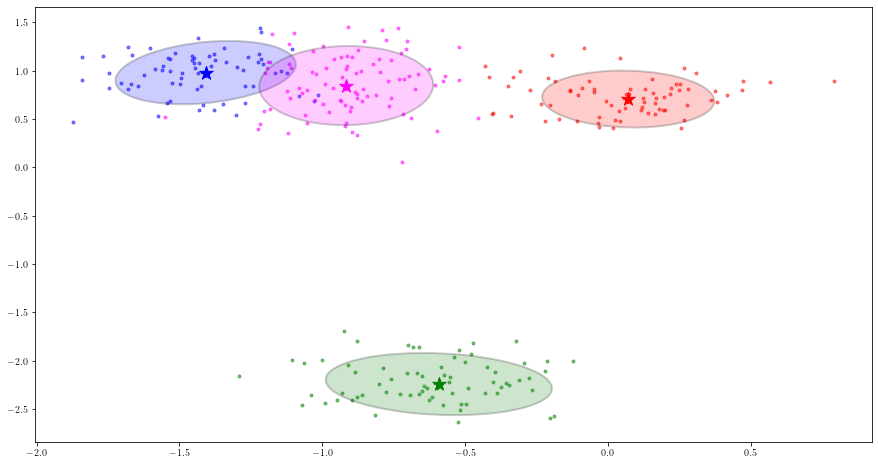

In [5]:
np.random.seed(4)

k = 4
z, x, true_mus, true_sigmas = sample_oneclass_mixture(k=k, sigma0=2, df=20, N=300)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plot_points(ax, x, np.argmax(z, axis=1), mus=true_mus, sigmas=2 * true_sigmas, points_alpha=.5)
plt.show()

In [6]:
def e_step(xs, pis, mus, sigmas):
    k = mus.shape[0]
    z = np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ])
    ## здесь z_{nk} = p(C_k)p(x_n|C_k)
    z = np.divide( z, np.sum(z, axis=0) ).T
    ## z_{nk} = p(C_k|x_n)
    return z

def m_step(xs, z):
    k = z.shape[1]
    pis = np.sum(z, axis=0) / np.sum(z)
    mus = np.array([np.average(xs, weights=z[:,i], axis=0) for i in range(k)])
    sigmas = np.array([np.cov(xs.T, aweights=z[:,i]) for i in range(k)])
    return pis, mus, sigmas

def loglikelihood(xs, pis, mus, sigmas):
    k = mus.shape[0]
    return np.sum(np.log(np.sum(np.array([ pis[i] * sp.stats.multivariate_normal.pdf(xs, mean=mus[i], cov=sigmas[i]) for i in range(k) ]), axis=0)))

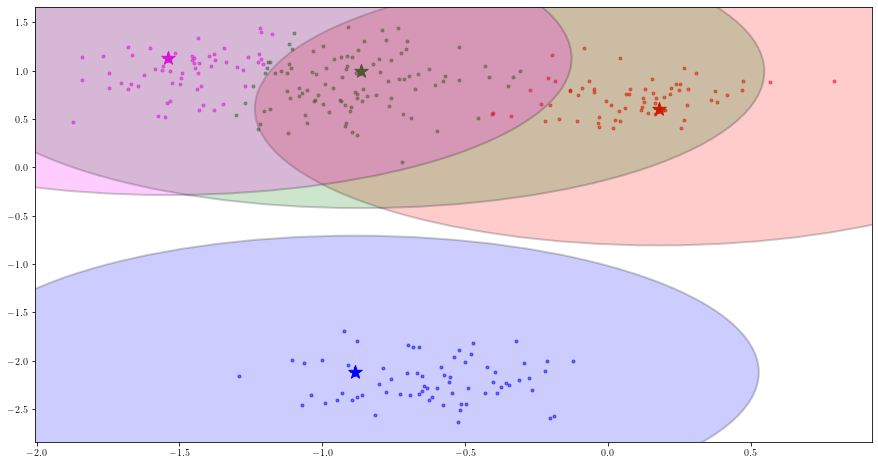

In [7]:
seed = 11
np.random.seed(seed)

k = 4
mus = x[ np.random.choice(x.shape[0], size=k, replace=False), : ]
sigmas = np.array( [ np.identity(2) for _ in range(k) ] )
pis = (1./k) * np.ones(k)
z = e_step( x, pis, mus, sigmas)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plot_points(ax, x, np.argmax(z, axis=1), mus=mus, sigmas=2 * sigmas, points_alpha=.5)
plt.show()

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


def step_slice(lst, step):
    return lst[step]


def animate_list(lst, play=False, interval=200):
    slider = widgets.IntSlider(min=0, max=len(lst) - 1, step=1, value=0)
    if play:
        play_widjet = widgets.Play(interval=interval)
        widgets.jslink((play_widjet, 'value'), (slider, 'value'))
        display(play_widjet)
        # slider = widgets.Box([play_widject, slider])
    return interact(step_slice,
                    lst=fixed(lst),
                    step=slider)

In [9]:
## EM-алгоритм
np.random.seed(seed)

k = 4
mus = x[ np.random.choice(x.shape[0], size=k, replace=False), : ]
sigmas = np.array( [ np.identity(2) for _ in range(k) ] )
pis = (1./k) * np.ones(k)
z = e_step( x, pis, mus, sigmas)

old_logl, new_logl = -np.inf, -np.inf
plots = []
for iIter in range(5000):
    old_logl = new_logl
    z = e_step( x, pis, mus, sigmas)
    # print(z)
    new_pis, new_mus, new_sigmas = m_step(x, z)
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    plot_points(ax, x, np.argmax(z, axis=1), mus=new_mus, sigmas=2 * new_sigmas, points_alpha=.5)
    plt.close(fig) # to show using interactive
    plots.append(fig) # to show using interactive
#     plt.show() # to show without interactive
    pis, mus, sigmas = new_pis, new_mus, new_sigmas
    new_logl = loglikelihood(x, pis, mus, sigmas)
    print("Логарифм правдоподобия на итерации %03d: %.6f" % (iIter, new_logl) )
    if np.abs(new_logl - old_logl) < 0.01:
        break

print("После %d итераций правдоподобие = %.6f" % (iIter, new_logl) )

Логарифм правдоподобия на итерации 000: -432.902138
Логарифм правдоподобия на итерации 001: -377.488388
Логарифм правдоподобия на итерации 002: -373.640810
Логарифм правдоподобия на итерации 003: -368.536145
Логарифм правдоподобия на итерации 004: -363.650049
Логарифм правдоподобия на итерации 005: -360.106778
Логарифм правдоподобия на итерации 006: -356.984854
Логарифм правдоподобия на итерации 007: -353.546405
Логарифм правдоподобия на итерации 008: -349.581989
Логарифм правдоподобия на итерации 009: -344.953468
Логарифм правдоподобия на итерации 010: -340.161394
Логарифм правдоподобия на итерации 011: -336.892355
Логарифм правдоподобия на итерации 012: -335.515215
Логарифм правдоподобия на итерации 013: -335.014237
Логарифм правдоподобия на итерации 014: -334.807233
Логарифм правдоподобия на итерации 015: -334.695509
Логарифм правдоподобия на итерации 016: -334.615263
Логарифм правдоподобия на итерации 017: -334.545694
Логарифм правдоподобия на итерации 018: -334.479683
Логарифм пра

In [10]:
print(len(plots))
animate_list(plots, play=True, interval=2000)

77


Play(value=0, interval=2000)

interactive(children=(IntSlider(value=0, description='step', max=76), Output()), _dom_classes=('widget-interac…

<function __main__.step_slice(lst, step)>

[0.1973 0.2333 0.3348 0.2345]


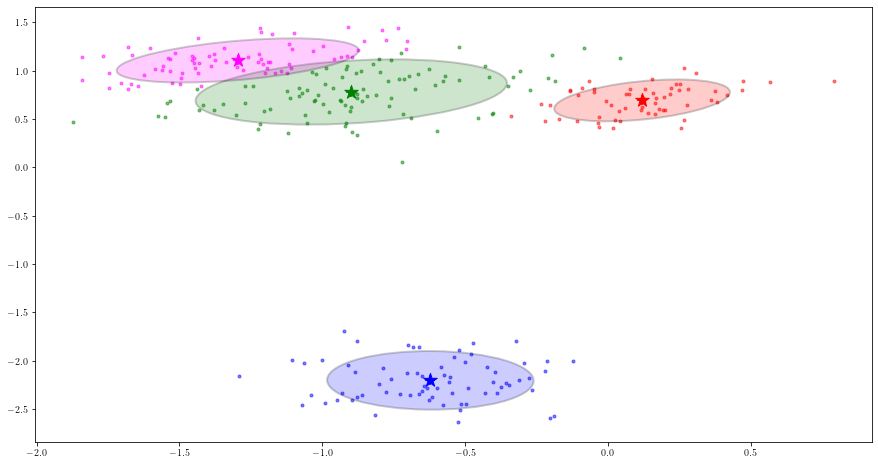

In [10]:
print(pis)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plot_points(ax, x, np.argmax(z, axis=1), mus=new_mus, sigmas=2 * new_sigmas, points_alpha=.5)
plt.show()

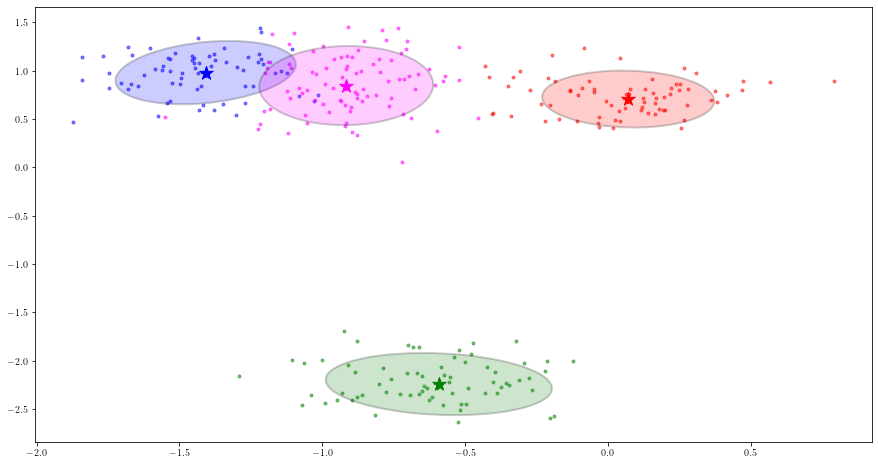

In [11]:
np.random.seed(4)

k = 4
z, x, true_mus, true_sigmas = sample_oneclass_mixture(k=k, sigma0=2, df=20, N=300)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
plot_points(ax, x, np.argmax(z, axis=1), mus=true_mus, sigmas=2 * true_sigmas, points_alpha=.5)
plt.show()

# Конец